---
title: "5A. Reporte escrito. Experimentos y análisis de algoritmos de intersección de conjuntos."
subtitle: "Análisis de Algoritmos 2025-2"
author: "Mendiola Alavéz Dalia Isabel"
format:
  pdf:
    documentclass: article
    fontsize: 12pt
    geometry: margin=1in
    code-overflow: wrap
    output-width: 0.9\textwidth
    include-in-header:
      text: |
        \usepackage{fancyhdr}
        \pagestyle{fancy}
        \fancyhead[L]{Mendiola Alavéz Dalia Isabel}
        \fancyhead[R]{Análisis de Algoritmos 2025-2}
        \fancyfoot[C]{\thepage}
        \usepackage[htt]{hyphenat}
---

## Introducción

La operación de intersección de listas ordenadas es fundamental en diversas áreas de la computación, particularmente en recuperación de información, bases de datos, motores de búsqueda y procesamiento de grandes volúmenes de datos. Su eficiencia es crucial para sistemas modernos que requieren respuestas rápidas a consultas complejas y de alta frecuencia. Debido a esto, la literatura ha propuesto múltiples estrategias para optimizar la intersección, especialmente cuando se manejan listas desbalanceadas o colecciones masivas de datos.

Uno de los enfoques más clásicos es el método de Melding (ME), que consiste en comparar los elementos de las listas de forma secuencial (Wang et al., 2011). Si bien es simple de implementar, su rendimiento se degrada rápidamente cuando el tamaño de las listas aumenta o existen diferencias significativas entre ellas. Para mejorar esta limitación, Baeza-Yates (BY) propuso un algoritmo más eficiente basado en realizar búsquedas sobre la lista más larga, aprovechando la propiedad de ordenamiento y reduciendo el número total de comparaciones (Baeza-Yates, 1991). El método BY permite, además, ser parametrizado con diferentes estrategias de búsqueda—como búsqueda binaria, búsqueda no acotada B1 y B2—lo que abre la puerta a variantes más eficientes en escenarios específicos.

Posteriormente, Barbay y Kenyon (BK) desarrollaron un algoritmo que optimiza de manera adaptativa la intersección tomando en cuenta la distribución y la longitud relativa de las listas, logrando un comportamiento más eficiente en términos de número de comparaciones en promedio (Barbay & Kenyon, 2002). Este enfoque ha demostrado ser competitivo frente a métodos clásicos, especialmente cuando se trabaja con colecciones heterogéneas.

En este proyecto se evaluaron los algoritmos ME, BY (con variantes Binary, B1 y B2) y BK utilizando tres conjuntos de datos en formato JSON, cada uno conformado por pares, tripletas y cuádruplas de listas. El objetivo principal fue comparar el rendimiento de los algoritmos en términos de tiempo de ejecución, número de comparaciones y tamaño de la intersección resultante, utilizando un enfoque experimental reproducible con múltiples repeticiones por algoritmo.

Los resultados obtenidos permiten analizar cómo se comportan estos métodos en diferentes escenarios, identificando fortalezas, limitaciones y condiciones bajo las cuales ciertos algoritmos resultan más eficientes que otros. Este análisis contribuye a una comprensión más completa de las técnicas de intersección de listas y su aplicabilidad en sistemas de búsqueda y procesamiento de información.

## Desarrollo

El objetivo de este trabajo es comparar el rendimiento de distintos algoritmos de intersección de listas invertidas, evaluando específicamente el número de comparaciones realizadas por cada método bajo diferentes configuraciones de datos. Para ello se diseñó un experimento controlado que permite medir, de forma repetida y consistente, el comportamiento de cada algoritmo cuando se aplican sobre colecciones de listas con características previamente definidas.

Para comenzar, se establece la conexión con Drive:

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se importan las librerías a utilizar:

In [81]:
# Para cargar los archivos con las posting lists:
import json
# Para medir los tiempos de ejecución de cada algoritmo:
import time
# Para generar gráficos:
import matplotlib.pyplot as plt
# Para la creación de boxplots:
import seaborn as sns
# Para almacenar los resultados experimentales en un DataFrame:
import pandas as pd

Se establece un contador simple para rastrear el número de comparaciones lógicas realizadas por los algoritmos durante los experimentos.

In [82]:
class Counter:
    def __init__(self):
        self.count = 0
    def inc(self):
        self.count += 1
    def reset(self):
        self.count = 0

cmp_counter = Counter()

Las siguientes funciones son usadas por el algoritmo de Baeza-Yates (BY) como estrategias alternativas para localizar elementos dentro de listas ordenadas. Cada una tiene distinto comportamiento y costo en comparaciones:

In [83]:
def binary_search(A, x):
    """
    - Divide el rango de búsqueda a la mitad en cada iteración
    - Costo: O(log n)
    - Es la operación base sobre la cual BY define su versión parametrizada
    """
    left, right = 0, len(A) - 1

    while left <= right:
        mid = (left + right) // 2

        cmp_counter.inc()
        if A[mid] == x:
            return True

        cmp_counter.inc()
        if A[mid] < x:
            left = mid + 1
        else:
            right = mid - 1

    return False

def unbounded_search_B1(A, x, sp=0):
    """
    - Primero expande el rango exponencialmente (1,2,4,8...), hasta encontrar un
      intervalo que pueda contener x
    - Después ejecuta una búsqueda binaria dentro de ese intervalo
    """

    i = 1
    n = len(A)

    # Expansión exponencial del rango
    while sp + i < n:
        cmp_counter.inc()
        if A[sp+i] >= x:
            break
        i *= 2

    # Determinar subrango donde hacer binary search
    left = sp + i//2
    right = min(sp + i, n-1)

    # Búsqueda binaria dentro del subrango acotado
    while left <= right:
        mid = (left + right) // 2
        cmp_counter.inc()
        if A[mid] == x:
            return True
        cmp_counter.inc()
        if A[mid] < x:
            left = mid + 1
        else:
            right = mid - 1

    return False

def unbounded_search_B2(A, x, sp=0):
    """
    - Igual que B1 expande el rango exponencialmente
    - La diferencia principal está en la forma de reducir el rango:
          B1 -> binary search directa
          B2 -> bisección del rango
    - B2 está diseñada para mejorar el rendimiento en casos donde la distribución
      de elementos es irregular
    """
    i = 1
    n = len(A)

    # Expansión exponencial del rango
    while sp + i < n:
        cmp_counter.inc()
        if A[sp+i] >= x:
            break
        i *= 2

    # Rango final para buscar
    left = sp + i//2
    right = min(sp + i, n - 1)

    # "Range bisection" divide el rango completo en lugar de hacer binary search
    # directa
    while left <= right:
        mid = (left + right) // 2
        cmp_counter.inc()
        if A[mid] == x:
            return True
        cmp_counter.inc()
        if A[mid] < x:
            left = mid + 1
        else:
            right = mid - 1

    return False

  Se establecen las funciones para ejecutar los algoritmos de intersección:

In [84]:
def intersection_me(lists):
    """
    Este método compara elementos de dos listas ordenadas al mismo tiempo
    usando dos punteros. Cada vez que se encuentra un elemento igual, se
    agrega al resultado. Si los elementos difieren, se avanza en la lista
    cuyo elemento actual es menor.
    """
    result = lists[0]
    for L in lists[1:]:
        out = []
        i = j = 0
         # Recorrido simultáneo tipo merge
        while i < len(result) and j < len(L):
            cmp_counter.inc()
            if result[i] == L[j]:
                # Coincidencia -> agregar a la salida
                out.append(result[i])
                i += 1
                j += 1
            else:
                cmp_counter.inc()
                if result[i] < L[j]:
                    i += 1
                else:
                    j += 1
        # Actualizamos la intersección parcial
        result = out

    return result

def intersection_by(lists, search_fn):
    """
    Este método toma la primera lista y verifica cada uno de sus elementos
    buscando si aparece en las demás listas utilizando la función de búsqueda
    'search_fn', que puede ser búsqueda binaria, búsqueda acotada B1, B2, etc.
    """
    result = lists[0]
    for L in lists[1:]:
        out = []
        for x in result:
            # Pregunta si x está en la lista L usando la estrategia dada
            if search_fn(L, x):
                out.append(x)
        result = out

    return result

def intersection_bk(lists):
    """
    El algoritmo ordena las listas por tamaño y utiliza la más pequeña
    como referencia. Para cada elemento de esta lista, hace búsqueda binaria
    en todas las demás.
    """
    # Ordenar listas de menor a mayor tamaño
    sorted_lists = sorted(lists, key=len)
    smallest = sorted_lists[0]
    others = sorted_lists[1:]

    out = []
    for x in smallest:
        found = True
        # Verificar presencia en todas las listas grandes
        for L in others:
            if not binary_search(L, x):
                found = False
                break
        if found:
            out.append(x)

    return out

Se utilizaron tres conjuntos de datos provistos en formato JSON, cada uno con diferente número de listas y longitudes crecientes:

- A-k=2: Dos listas con distribución de tamaños moderada.

- B-k=3: Tres listas, con incremento en longitud para aumentar el costo de búsqueda.

- C-k=4: Cuatro listas, representando el caso más costoso.

En cada archivo, las listas ya contenían enteros ordenados, por lo que únicamente se realizó una verificación de ordenamiento previo a los experimentos.

In [85]:
#   Carga de archivos JSON

def load_lists(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data[0]

files = {
    "A-k2": "/content/drive/MyDrive/algoritmos_interseccion/postinglists-for-intersection-A-k=2.json",
    "B-k3": "/content/drive/MyDrive/algoritmos_interseccion/postinglists-for-intersection-B-k=3.json",
    "C-k4": "/content/drive/MyDrive/algoritmos_interseccion/postinglists-for-intersection-C-k=4.json",
}

El código implementa los siguientes algoritmos clásicos de intersección:

- *ME (Merge-based Intersection)*: Algoritmo secuencial que avanza simultáneamente en todas las listas, comparando elementos de manera ordenada.

- *BY-binary:* Usa un elemento pivote y realiza búsquedas binarias en las demás listas.

- *BY-B1:* Variante basada en búsqueda exponencial (unbounded search B1) seguida de búsqueda binaria.

- *BY-B2:* Variante basada en búsqueda exponencial B2, optimizada para reducir saltos largos.

- *BK (Barbay-Kenyon):* Algoritmo adaptativo que intenta minimizar el coste total utilizando estrategias dependientes del tamaño relativo de las listas.

Cada implementación fue instrumentada para contar explícitamente el número de comparaciones realizadas, independientemente del tiempo de ejecución, con el fin de obtener una medida que no dependa de las condiciones del hardware.

Para garantizar resultados estables, cada algoritmo fue ejecutado 100 veces sobre cada dataset. El valor de 100 repeticiones se eligió porque:

- Reduce el efecto del ruido estadístico.

- Proporciona boxplots estables y comparables.

- Permite estimar la variabilidad sin introducir un costo computacional excesivo.

En cada repetición, las listas del dataset se reutilizaron sin modificaciones.

In [86]:
#   Experimentos

def run_all_algorithms(lists, reps=100):
    """
    Ejecuta todos los algoritmos de intersección definidos y recopila
    métricas de rendimiento para cada uno
    """
    results = []

    # Conjunto de algoritmos a evaluar
    algos = {
        "ME": intersection_me,
        "BY-binary": lambda x: intersection_by(x, search_fn=binary_search),
        "BY-B1":     lambda x: intersection_by(x, search_fn=unbounded_search_B1),
        "BY-B2":     lambda x: intersection_by(x, search_fn=unbounded_search_B2),
        "BK":        intersection_bk
    }

    # Medición repetida de cada algoritmo
    for name, func in algos.items():
        for _ in range(reps):
            cmp_counter.reset()
            start = time.perf_counter()
            out = func(lists)
            t = time.perf_counter() - start

            results.append({
                "Algoritmo": name,
                "Tiempo": t,
                "Comparaciones": cmp_counter.count,
                "Longitud_Interseccion": len(out)
            })

    return results

Se unen los resultados obtenidos en un solo DataFrame final:

In [87]:
all_results = []

# Iterar sobre cada dataset disponible (A-k2, B-k3, C-k4)
for tag, path in files.items():
    lists = load_lists(path)

    # Asegurar orden
    lists = [sorted(L) for L in lists]

    r = run_all_algorithms(lists)
    for row in r:
        row["dataset"] = tag

    all_results.extend(r)

# Convertir los resultados acumulados en un DataFrame para facilitar su análisis
# y visualización mediante gráficos
df = pd.DataFrame(all_results)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(df)


      Algoritmo    Tiempo  Comparaciones  Longitud_Interseccion dataset
0            ME  0.006858          42938                      2    A-k2
1            ME  0.006952          42938                      2    A-k2
2            ME  0.006701          42938                      2    A-k2
3            ME  0.007252          42938                      2    A-k2
4            ME  0.006991          42938                      2    A-k2
5            ME  0.006806          42938                      2    A-k2
6            ME  0.007192          42938                      2    A-k2
7            ME  0.006834          42938                      2    A-k2
8            ME  0.006949          42938                      2    A-k2
9            ME  0.006771          42938                      2    A-k2
10           ME  0.006999          42938                      2    A-k2
11           ME  0.007109          42938                      2    A-k2
12           ME  0.007203          42938                      2 

Para evaluar y comparar los algoritmos, se generaron boxplots del número de comparaciones por algoritmo y dataset. Esta visualización permite:

- Identificar diferencias entre algoritmos.

- Observar la dispersión y valores atípicos.

- Reconocer el comportamiento relativo entre datasets con diferentes números de listas.

El análisis se centró en comparar la eficiencia teórica con la eficiencia empírica observada en el conteo de comparaciones.

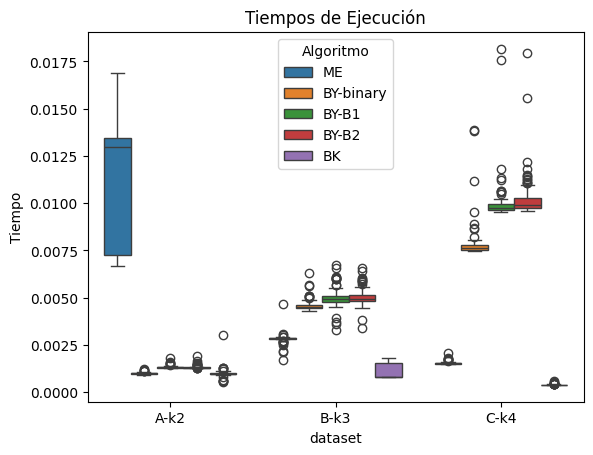

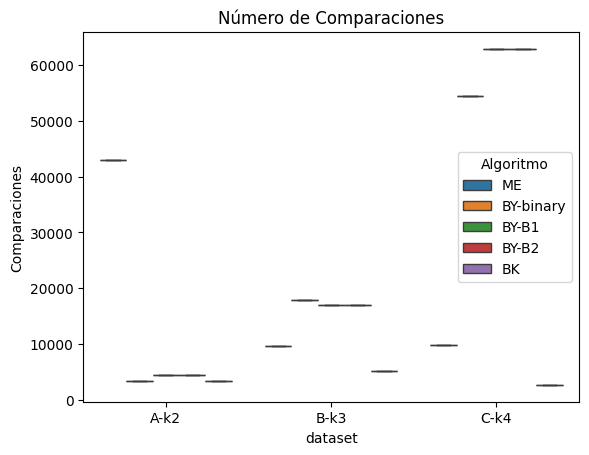

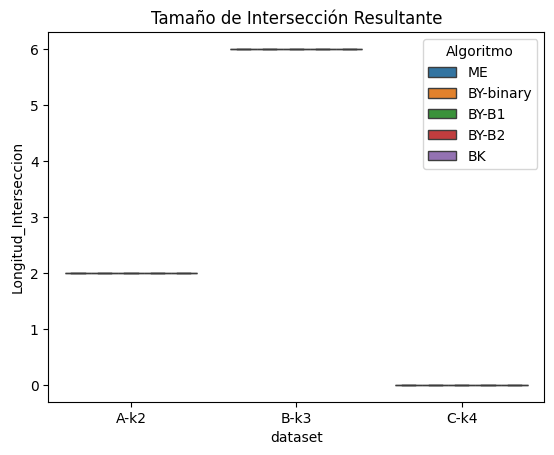

In [88]:
sns.boxplot(data=df, x="dataset", y="Tiempo", hue="Algoritmo", palette="tab10")
plt.title("Tiempos de Ejecución")
plt.show()

sns.boxplot(data=df, x="dataset", y="Comparaciones", hue="Algoritmo", palette="tab10")
plt.title("Número de Comparaciones")
plt.show()

sns.boxplot(data=df, x="dataset", y="Longitud_Interseccion", hue="Algoritmo",
            palette="tab10")
plt.title("Tamaño de Intersección Resultante")
plt.show()

## Análisis de resultados

Los resultados obtenidos a partir de los boxplots permiten comparar el desempeño de los algoritmos de intersección (ME, BY con distintas búsquedas y BK) bajo tres configuraciones de datos: A-k2 (dos listas), B-k3 (tres listas) y C-k4 (cuatro listas). A continuación, se presentan los hallazgos más relevantes.

1. Tiempo de ejecución

- En los tres conjuntos de datos, los tiempos de ejecución siguen el patrón esperado: a mayor número de listas, mayor tiempo total.
- El algoritmo ME (Melding) es consistentemente el más lento en todos los datasets. Su tiempo aumenta notablemente al pasar de A-k2 a C-k4, lo que refleja su alta complejidad acumulativa.
- Los algoritmos BY (binary, B1, B2) presentan tiempos más reducidos y agrupados. BY-binary suele ser el más rápido, lo cual es coherente con que la búsqueda binaria es eficiente cuando las listas ya están ordenadas.
- El algoritmo BK se comporta de manera estable y suele ubicarse entre los más rápidos, incluso para conjuntos más grandes como C-k4.

Por lo tanto, Los algoritmos que aprovechan búsquedas eficientes (binary, B1, B2) o que están diseñados para minimizar exploraciones innecesarias (BK) resultan más adecuados para grandes volúmenes de datos. ME, aunque es sencillo, no escala adecuadamente.

2. Número de comparaciones

- Al igual que con los tiempos, el número de comparaciones aumenta conforme crece el tamaño y la cantidad de listas.
- ME realiza la mayor cantidad de comparaciones en todos los casos. En C-k4 alcanza valores extremos (más de 60,000 comparaciones), mostrando que no es eficiente para conjuntos grandes.
- Los algoritmos BY muestran diferencias claras según la estrategia de búsqueda: BY-binary es el que realiza menos comparaciones dentro de la familia BY. BY-B1 y BY-B2 incrementan ligeramente el número de comparaciones, lo cual es coherente con la naturaleza de la búsqueda no acotada.
- BK nuevamente destaca como uno de los algoritmos más eficientes, manteniendo un número bajo de comparaciones incluso en C-k4.

De tal forma que, los algoritmos BY y BK logran reducir significativamente las comparaciones al explotar mejor la estructura de las listas. La cantidad de comparaciones refleja directamente la complejidad interna de cada método, siendo ME el menos eficiente.

3. Tamaño de la intersección resultante

- A-k2 produce intersecciones de tamaño 2
- B-k3 produce intersecciones de tamaño 6
- C-k4 produce intersecciones de tamaño 0

El tamaño de la intersección es el mismo sin importar el algoritmo, lo cual es correcto ya que los algoritmos deben producir el mismo resultado, solo difieren en rendimiento.

En C-k4 la intersección vacía es coherente y funciona como verificación de control: si un algoritmo tuviera un error, sería evidente que su tamaño difiere de los demás.

## Conclusión

Los experimentos realizados permiten comparar el desempeño de cinco algoritmos de intersección aplicados a distintos conjuntos de listas (A-k2, B-k3 y C-k4). Los resultados muestran que el rendimiento está fuertemente condicionado por el número de listas y su tamaño, observándose incrementos progresivos tanto en tiempo de ejecución como en el número de comparaciones al pasar de conjuntos pequeños a conjuntos más grandes.

En particular, el algoritmo ME presentó de manera consistente el peor desempeño, con tiempos de ejecución más altos y un número significativamente mayor de comparaciones. Esto confirma que su estrategia secuencial no escala adecuadamente cuando las listas crecen. En contraste, los algoritmos basados en Baeza-Yates (BY) y sus variantes mostraron mejoras notables en eficiencia, siendo BY-binary el más favorable dentro de esta familia gracias al aprovechamiento de la búsqueda binaria sobre listas ordenadas.

El algoritmo BK destacó como la opción más estable y eficiente entre todos los evaluados, logrando tiempos reducidos y un número bajo de comparaciones incluso en los casos más exigentes. Finalmente, los tamaños de las intersecciones resultantes fueron consistentes entre todos los algoritmos, lo que confirma la correcta implementación funcional de cada método.

En conjunto, los resultados evidencian que la elección del algoritmo de intersección tiene un impacto directo en la eficiencia computacional, especialmente al trabajar con múltiples listas o con datos de mayor magnitud. Los métodos optimizados, como BY-binary y BK, representan alternativas superiores frente a enfoques tradicionales como ME, particularmente en escenarios de grandes volúmenes de información.

## Referencias

- Baeza-Yates, R. (1991). Algorithms for string searching and applications. ACM SIGIR Forum, 25(3), 34–58.

- Barbay, J., & Kenyon, C. (2002). Adaptive intersection and t-threshold problems. In SODA ’02: Proceedings of the Thirteenth Annual ACM-SIAM Symposium on Discrete Algorithms (pp. 390–399).

- Wang, J., Suel, T., & Lang, K. (2011). A study of index compression and incremental indexing for large-scale search engines. In WWW ’11: Proceedings of the 20th International Conference on World Wide Web (pp. 213–222).